## About the CIFAR-10 dataset

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) (classification of small images across 10 distinct classes---airplane, automobile, bird, cat, deer, dog, frog, horse, ship & truck).


![](cifar_10.png)

The CIFAR-10 dataset contains 50000 training examples and 10000 test examples. Each example is a $32 \times 32 \times 32$ pixels coloured image.

## Loading and pre-processing CIFAR-10 dataset



(50000, 32, 32, 3)
(10000, 32, 32, 3)


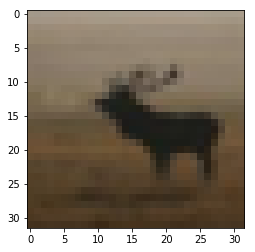

deer


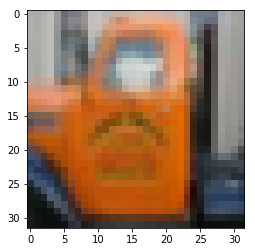

truck


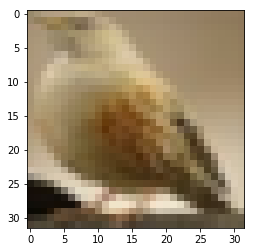

bird
(50000, 3072)
(10000, 3072)
[[ 0.67058825  0.67450982  0.65490198 ...,  0.05882353  0.0627451
   0.05490196]
 [ 0.59607846  0.5411765   0.42352942 ...,  0.38039216  0.34509805
   0.26274511]
 [ 0.00392157  0.01176471  0.00392157 ...,  0.27450982  0.28627452
   0.19215687]
 [ 0.8509804   0.8392157   0.81176472 ...,  0.89803922  0.89803922
   0.88627452]]


In [6]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
os.environ['KERAS_BACKEND']="tensorflow"

from keras.datasets import cifar10 # subroutines for fetching the CIFAR-10 dataset
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
from sklearn.utils import shuffle
from skimage import feature

(X_train_img, y_train), (X_test_img, y_test) = cifar10.load_data() # fetch CIFAR-10 data # dirname="."??
print(X_train_img.shape)
print(X_test_img.shape)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Shuffle examples
X_train_img, y_train = shuffle(X_train_img, y_train)
X_test_img, y_test = shuffle(X_test_img, y_test)

plt.figure()
plt.imshow(X_train_img[0])
plt.show()
print(class_names[int(y_train[0])])
plt.figure()
plt.imshow(X_train_img[1])
plt.show()
print(class_names[int(y_train[1])])
plt.figure()
plt.imshow(X_train_img[2])
plt.show()
print(class_names[int(y_train[2])])

num_train, depth, height, width = X_train_img.shape # there are 50000 training examples in CIFAR-10 
num_test = X_test_img.shape[0] # there are 10000 test examples in CIFAR-10
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

# Produce a [0;1] normalized "image" for potential input into a convNet
X_train_img_norm = X_train_img.astype('float32') 
X_test_img_norm = X_test_img.astype('float32')
X_train_img_norm /= np.max(X_train_img_norm) # Normalise data to [0, 1] range
X_test_img_norm /= np.max(X_train_img_norm) # Normalise data to [0, 1] range

# Rasterize normalized images into 1D vectors for potential input of raw image into standard ML algo such as kNN, MLP, SVM, etc
X_train_vectNorm = X_train_img_norm.reshape(num_train,height*width*depth)
X_test_vectNorm = X_test_img_norm.reshape(num_test,height*width*depth)

print(X_train_vectNorm.shape)
print(X_test_vectNorm.shape)
print(X_train_vectNorm[1:5])


# Compute HOG feature as potential BETTER input into standard ML algo such as kNN, MLP, SVM, etc

#Hog_train = []
#for img in X_train_img :
#    hog, hog_image = skimage.feature.hog(img, orientations=9, pixels_per_cell=(8, 8), 
#                                    cells_per_block=(3, 3), block_norm=None, 
#                                    visualise=True, transform_sqrt=False, feature_vector=True)
#    Hog_train.append(hog)

# TO BE CORRECTED/FINALIZED!...


# Une fonction pour afficher graphiquement les matrices de confusion

In [7]:
#%matplotlib inline
import matplotlib.pyplot as plt
import itertools

# Definition for the function that plot the confusion matrix
# See : http://www.sci-kit.org/
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Baseline method: kNN on raw normalized pixels

(50000, 1)
[[1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [ 998    0    0    0    0    0    2    0    0    0]
 [ 997    0    0    0    0    2    1    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [ 998    0    0    1    0    0    1    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [ 999    0    0    1    0    0    0    0    0    0]
 [ 999    1    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]]
Normalized confusion matrix
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

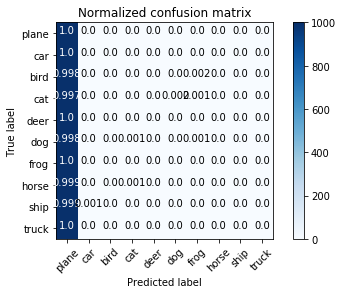

In [8]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

clf = neighbors.KNeighborsClassifier(n_neighbors=5)
print(y_train.shape)
clf.fit(X_train_vectNorm[:30000], y_train.ravel()[:30000]) # utiliser toutes les données conduit à une Memory Error

y_test_pred_knn = clf.predict(X_test_vectNorm)


cnf_matrix_knn = confusion_matrix(y_test, y_test_pred_knn)
print(cnf_matrix_knn)

np.set_printoptions(precision=2)
plt.figure()
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix_knn, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Remarques sur les résultats :

La matrice de confusion est très mauvaise : toutes les images sont vues comme appartenant à la première classe. Comparer les pixels des images n'est pas une méthode très pertinente pour classifier les images. Par ailleurs, l'algorithme des plus proches voisins est très lent à s'exécuter, et utilise beaucoup de mémoire : nous avons dû limiter la taille du jeu d'entraînement pour ne pas avoir d'erreur de mémoire.

## Random Forests on raw normalized pixels

n_estimators= 10  max_depth= None max_features= auto
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy (on test set) =  0.0992
             precision    recall  f1-score   support

      plane       0.06      0.01      0.01      1000
        car       0.00      0.00      0.00      1000
       bird       0.10      0.98      0.18      1000
        cat       0.18      0.00      0.01      1000
       deer       0.00      0.00      0.00      1000
        dog       0.00      0.00      0.00      1000
       frog       0.00      0.00      0.00      1000
      horse       0.00      0.00      0.00      1000
       ship  

/home/lmeyrat/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalized confusion matrix
[[ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.    0.97  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.98  0.    0.    0.    0.    0.    0.    0.  ]]


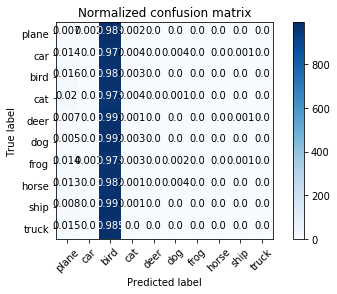

In [9]:
#Random Forests

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None)
clf = clf.fit(X_train_vectNorm, y_train.ravel())

print("n_estimators=", clf.n_estimators, " max_depth=",clf.max_depth,
      "max_features=", clf.max_features)
print(clf)

# accuracy :
score = clf.score(X_test_vectNorm, y_test)
print("Accuracy (on test set) = ", score)

# resultats et matrice de confusion
y_true, y_pred_rf = y_test, clf.predict(X_test_vectNorm)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print( classification_report(y_true, y_pred_rf, target_names=class_names) )

print("\n CONFUSION MATRIX")
cnf_matrix_rf=confusion_matrix(y_true, y_pred_rf)
print( cnf_matrix_rf )
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [12]:
import os
os.environ['KERAS_BACKEND']="tensorflow"
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(42, input_dim=32*32*3))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('sigmoid'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_vectNorm, Y_train, epochs=20, batch_size=32)

y_test_pred_mlp = model.predict(X_train_vectNorm)


cnf_matrix_mlp = confusion_matrix(y_test, y_test_pred_mlp)
print(cnf_matrix_mlp)

np.set_printoptions(precision=2)
plt.figure()
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix_mlp, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()


Epoch 1/20
50000/50000 [==============================] - 4s - loss: 1.9462 - acc: 0.3004     
Epoch 2/20
50000/50000 [==============================] - 4s - loss: 1.7818 - acc: 0.3653     
Epoch 3/20
50000/50000 [==============================] - 4s - loss: 1.7151 - acc: 0.3895     
Epoch 4/20
50000/50000 [==============================] - 4s - loss: 1.6777 - acc: 0.4033     
Epoch 5/20
50000/50000 [==============================] - 4s - loss: 1.6468 - acc: 0.4145     
Epoch 6/20
50000/50000 [==============================] - 4s - loss: 1.6189 - acc: 0.4259     
Epoch 7/20
50000/50000 [==============================] - 4s - loss: 1.6006 - acc: 0.4321     
Epoch 8/20
50000/50000 [==============================] - 4s - loss: 1.5778 - acc: 0.4385     
Epoch 9/20
50000/50000 [==============================] - 4s - loss: 1.5635 - acc: 0.4431     
Epoch 10/20
50000/50000 [==============================] - 4s - loss: 1.5546 - acc: 0.4489     
Epoch 11/20
50000/50000 [========================

ValueError: Found input variables with inconsistent numbers of samples: [10000, 50000]